In [10]:
# sys.path.append('naturecomm_cscg')

# !pip install cairocffi
# !pip install python-igraph==0.9.8
# !pip install cairocffi
# !pip install igraph==0.9.8

from cscg_actions import *
from ged import *
from util import *


import pickle
import numpy as np


In [11]:
# import numpy as np

def generate_custom_colors(num_unique_observations):
    # Define a fixed set of custom colors as RGB values
    predefined_colors = np.array([
        [214, 214, 214],
        [85, 35, 157],
        [253, 252, 144],
        [114, 245, 144],
        [151, 38, 20],
        [239, 142, 192],
        [214, 134, 48],
        [140, 194, 250],
        [72, 160, 162],
    ])

    # If the number of unique observations is greater than the number of predefined colors,
    # cycle through the predefined colors to ensure enough colors are available
    if num_unique_observations > len(predefined_colors):
        extra_colors_needed = num_unique_observations - len(predefined_colors)
        additional_colors = np.tile(predefined_colors, (extra_colors_needed // len(predefined_colors) + 1, 1))
        custom_colors = np.vstack((predefined_colors, additional_colors))[:num_unique_observations]
    else:
        custom_colors = predefined_colors[:num_unique_observations]

    return custom_colors


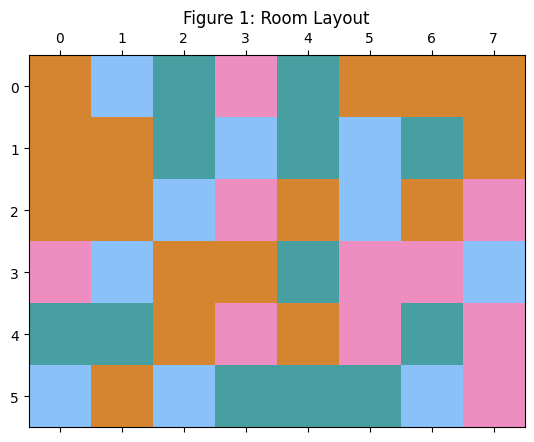

In [3]:
# room = np.array(
#     [
#         [1, 2, 3, 0, 3,],
#         [1, 1, 3, 2, 3,],
#         [1, 1, 2, 0, 1,],
#         [0, 2, 1, 1, 3,],
#         [3, 3, 1, 0, 1,],
#         [2, 1, 2, 3, 3,],
#     ]
# )

# Uncomment this for generating data from a bigger room. Will take longer to train.

room = np.array(
    [
        [1, 2, 3, 0, 3, 1, 1, 1],
        [1, 1, 3, 2, 3, 2, 3, 1],
        [1, 1, 2, 0, 1, 2, 1, 0],
        [0, 2, 1, 1, 3, 0, 0, 2],
        [3, 3, 1, 0, 1, 0, 3, 0],
        [2, 1, 2, 3, 3, 3, 2, 0],
    ]
)


# Plot the layout of the room
cmap = colors.ListedColormap(custom_colors[-4:])
plt.matshow(room, cmap=cmap)
plt.title('Figure 1: Room Layout')
plt.savefig("figures/rectangular_room_layout.pdf")

In [12]:
# import numpy as np
import igraph as ig


def grid_to_directed_igraph(grid):
    """
    Convert a 2D numpy array to a directed igraph.Graph.
    Each cell has bidirectional connections to its horizontal and vertical neighbors.
    """
    rows, cols = grid.shape
    adjacency_matrix = np.zeros((rows * cols, rows * cols), dtype=int)

    index = lambda r, c: r * cols + c

    for r in range(rows):
        for c in range(cols):
            current_index = index(r, c)

            # North
            if r > 0:
                north_index = index(r - 1, c)
                adjacency_matrix[current_index, north_index] = 1
                adjacency_matrix[north_index, current_index] = 1

            # South
            if r < rows - 1:
                south_index = index(r + 1, c)
                adjacency_matrix[current_index, south_index] = 1
                adjacency_matrix[south_index, current_index] = 1

            # East
            if c < cols - 1:
                east_index = index(r, c + 1)
                adjacency_matrix[current_index, east_index] = 1
                adjacency_matrix[east_index, current_index] = 1

            # West
            if c > 0:
                west_index = index(r, c - 1)
                adjacency_matrix[current_index, west_index] = 1
                adjacency_matrix[west_index, current_index] = 1

    # Creating an igraph from the adjacency matrix
    graph = ig.Graph.Adjacency((adjacency_matrix > 0).tolist(), mode=ig.ADJ_DIRECTED)
    return graph

# Example room array
room = np.array([
    [1, 2, 3, 0, 3, 1, 1, 1],
    [1, 1, 3, 2, 3, 2, 3, 1],
    [1, 1, 2, 0, 1, 2, 1, 0],
    [0, 2, 1, 1, 3, 0, 0, 2],
    [3, 3, 1, 0, 1, 0, 3, 0],
    [2, 1, 2, 3, 3, 3, 2, 0],
])

directed_igraph = grid_to_directed_igraph(room)
print("Directed Graph Representation with igraph:")
print(directed_igraph)


Directed Graph Representation with igraph:
IGRAPH D--- 48 164 --
+ edges:
 0 ->  1  8         12 ->  4 11 13 20   24 -> 16 25 32      36 -> 28 35 37 44
 1 ->  0  2  9      13 ->  5 12 14 21   25 -> 17 24 26 33   37 -> 29 36 38 45
 2 ->  1  3 10      14 ->  6 13 15 22   26 -> 18 25 27 34   38 -> 30 37 39 46
 3 ->  2  4 11      15 ->  7 14 23      27 -> 19 26 28 35   39 -> 31 38 47
 4 ->  3  5 12      16 ->  8 17 24      28 -> 20 27 29 36   40 -> 32 41
 5 ->  4  6 13      17 ->  9 16 18 25   29 -> 21 28 30 37   41 -> 33 40 42
 6 ->  5  7 14      18 -> 10 17 19 26   30 -> 22 29 31 38   42 -> 34 41 43
 7 ->  6 15         19 -> 11 18 20 27   31 -> 23 30 39      43 -> 35 42 44
 8 ->  0  9 16      20 -> 12 19 21 28   32 -> 24 33 40      44 -> 36 43 45
 9 ->  1  8 10 17   21 -> 13 20 22 29   33 -> 25 32 34 41   45 -> 37 44 46
10 ->  2  9 11 18   22 -> 14 21 23 30   34 -> 26 33 35 42   46 -> 38 45 47
11 ->  3 10 12 19   23 -> 15 22 31      35 -> 27 34 36 43   47 -> 39 46


  3%|▎         | 3/100 [00:19<10:32,  6.52s/it, train_bps=2.44]


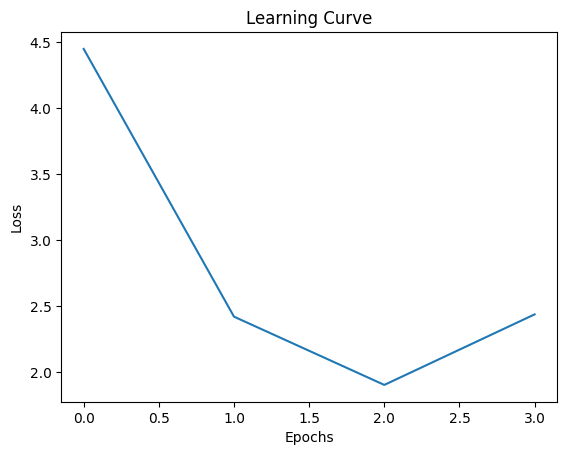

  0%|          | 0/100 [00:00<?, ?it/s]

viterbi C: (4, 36, 36)
viterbi T: (4, 36, 36)


 34%|███▍      | 34/100 [01:14<02:24,  2.19s/it, train_bps=1.65]


decode C: (4, 36, 36)
decode T: (4, 36, 36)
decode Pi: (4,)
decode n_clones: [10 12  5  9]
Ground truth number of nodes: 48, number of nodes recovered 36


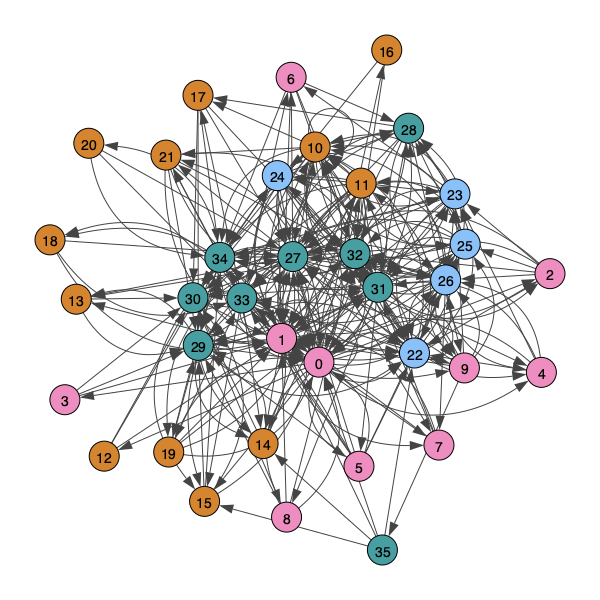

Room 0 has 10 tables (clones)
Room 1 has 12 tables (clones)
Room 2 has 5 tables (clones)
Room 3 has 9 tables (clones)
Total clones used: 36
Clones that would have been used by the original code: 280


In [5]:
# Generate data from the room and train a CSCG. Takes about a minute
# clones = np.arange(10, 220, 50)
# clones=[70]
# nclone = 70
# import igraph
n_emissions = room.max() + 1
nclone=1
a, x, rc = datagen_structured_obs_room(room, length=50000)     #Use length=50000 for bigger room
# for nclone in clones:
alphas = [1]
# for alpha in np.arange(0,1,0.3):
for alpha in alphas:
  n_clones = np.ones(n_emissions, dtype=np.int64) * nclone
  container = TableContainer()
  chmm = CHMM_LCM(n_clones=n_clones, pseudocount=2e-3, x=x, a=a, container=container,alpha=alpha,seed=42)  # Initialize the model
  progression = chmm.learn_em_T(x, a, n_iter=100,
                                # term_early=False,
                                )  # Training   use n_iter=1000 for better training
  # progression = chmm.learn_em_E(x, a, n_iter=1000)  # Training   use n_iter=1000 for better training

  # Consolidate learning. Takes a few seconds
  chmm.pseudocount = 0.0
  chmm.learn_viterbi_T(x, a, n_iter=100)

  # graph = plot_graph(
  #     chmm, x, a, output_file="figures/rectangular_room_graph.pdf", cmap=cmap
  # )
  # graph

  # cmap = colors.ListedColormap(custom_colors[arr])

  temp_output_file = f"rectangular_room_graph_large_num_clones_{nclone}.png"  # Temporary file for each clone
  graph, v, g = plot_graph(chmm, x, a, output_file=temp_output_file, cmap=cmap)
  print('Ground truth number of nodes: {}, number of nodes recovered {}'.format(len(room.flatten()), len(v)))





  # Display the image inline
  display(Image(filename=temp_output_file))



  n_clones = 0
  for roomid in range(len(container.groups_of_tables)):
    print("Room {} has {} tables (clones)".format(roomid, len(container.groups_of_tables[roomid])))
    n_clones+=len(container.groups_of_tables[roomid])
  print("Total clones used: {}".format(n_clones))
  print("Clones that would have been used by the original code: {}".format(len(container.groups_of_tables) * 70))


In [6]:
import pickle

In [7]:
with open('model_filename.pkl', 'wb') as file:
    pickle.dump(chmm, file)

In [18]:
n_emissions = room.max() + 1
nclone=1
a, x, rc = datagen_structured_obs_room(room, length=50000)     #Use length=50000 for bigger room
with open('model_lattice_alpha_0.1_seed_0.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

In [19]:
loaded_model

In [20]:
temp_output_file = f"rectangular_room_graph_large_num_clones_{nclone}.png"  # Temporary file for each clone
graph, v, g = plot_graph(loaded_model, x, a, output_file=temp_output_file, cmap=cmap)
display(Image(filename=temp_output_file))

decode C: (1, 42, 42)
decode T: (1, 42, 42)
decode Pi: (20,)
decode n_clones: [2 3 2 1 1 3 1 2 5 3 3 1 2 1 1 4 3 1 1 2]
Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/jungsun/opt/anaconda3/envs/cscg/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3526, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/0y/6z5lvyy15plflq56kf5szmhr0000gp/T/ipykernel_25933/2004926939.py", line 2, in <module>
    graph, v, g = plot_graph(loaded_model, x, a, output_file=temp_output_file, cmap=cmap)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/jungsun/Desktop/Repositories/CSCG_LCM/util.py", line 34, in plot_graph
    states = chmm.decode(x, a)[1]
             ^^^^^^^^^^^^^^^^^
  File "/Users/jungsun/Desktop/Repositories/CSCG_LCM/cscg_actions.py", line 281, in decode
    E = CE + self.pseudocount
                         ^^^^
  File "/Users/jungsun/Desktop/Repositories/CSCG_LCM/cscg_actions.py", line 950, in forward_mp
IndexError: index 2 is out of bounds for axis 0 with size 1

During handling of the above e